# Úloha 3
#### Pojišťovna má prediktivní model, pomocí něhož pro každého klienta odhaduje pravděpodobnost přežití následujících 10 let. Klienty podle toho rozdělí do dvou skupin (A – nízké riziko, B – vysoké riziko). Při zařazení klienta, který má ve skutečnosti nízké riziko, do skupiny B, vzniká čtyřikrát menší škoda než při opačné chybě (reálně vysokorizikový klient je zařazen do skupiny A).
#### Uveďte postup, jak byste stanovil(a) optimální hranici predikované pravděpodobnosti pro rozdělení klientů do skupin, nemáte-li již celá trénovací data, ale pouze ROC křivku z validační množiny, u níž pro každý bod křivky znáte odpovídající hodnotu hranice. (Skupina A u ROC křivky odpovídá negativním případům a skupina B pozitivním případům.)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### 1) Tvorba ROC křivky

In [3]:
# Testing model
data = pd.read_csv("./data/heart-disease.csv")
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

np.random.seed(52)

# data splitting 
x = data.drop("target", axis=1)
y = data["target"]


# splitng data into test and train datasets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# initialize model
model = RandomForestClassifier()

# fit model with datasets
model.fit(x_train, y_train)

# evaluate model
model.score(x_test, y_test)


0.8688524590163934

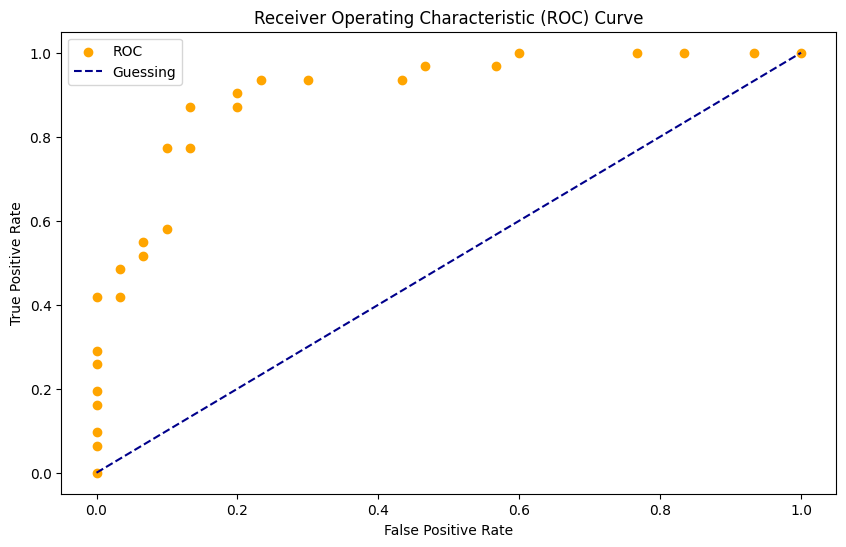

ROC AUC Score:  0.9123655913978496


array([ inf, 0.98, 0.97, 0.96, 0.95, 0.9 , 0.89, 0.86, 0.85, 0.8 , 0.79,
       0.77, 0.76, 0.6 , 0.59, 0.52, 0.46, 0.44, 0.4 , 0.33, 0.22, 0.2 ,
       0.17, 0.15, 0.07, 0.06, 0.01, 0.  ])

In [13]:
# Evaluation with the ROC curve
from sklearn.metrics import roc_curve, roc_auc_score

y_probs = model.predict_proba(x_test)
y_probs_positive = y_probs[:, 1] # all from second place
y_probs_negative = y_probs[:, 0] # all from first place

fpr, tpr, thresholds = roc_curve(y_test, y_probs_positive)


def plot_roc_curve(fpr, tpr):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(x=fpr, 
               y=tpr, 
               color="orange", 
               label="ROC")
    ax.plot([0,1], [0,1], color="darkblue", linestyle="--", label="Guessing")
    ax.set(xlabel="False Positive Rate", 
           ylabel="True Positive Rate", 
           title="Receiver Operating Characteristic (ROC) Curve")
    ax.legend()
    plt.show()

plot_roc_curve(fpr, tpr)
print("ROC AUC Score: ", roc_auc_score(y_test, y_probs_positive))
thresholds

### Stanovení optimální hranice predikční pravděpodobnosti 

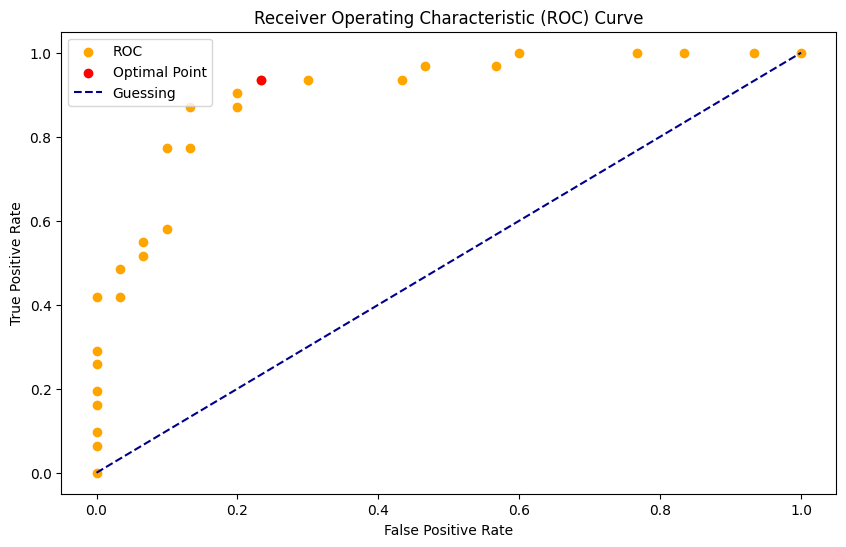

Optimal treshold for future evaluation: 0.4
Predikce pro klienta: [[0.6 0.4]]
Predikce pro klienta s ohledem na optimální práh pro kategorii A: False
Za normálních okolností bychom přiřadili klienta do kategorie 0 (A) s pravdepodobností 0.6, ale s ohledem na optimální práh pro kategorii B je klient zařazen do kategorie 1 (B)
Pokud bychom dostali predikci [0.61, 0.39], klient by již mohl být zařazen do kategorie A


In [40]:
# PŘEDPOKLAD: vyobrazená ROC křivka odpovídá zařazení klienta do kategorie B (pozitivní) = false positive (FP - false positive) do B je 4x méně nákladné než false negative do A (FN - false negative


# ROC AUC Score - výpočet plochy pod křivkou 
score = roc_auc_score(y_test, y_probs_positive)

# Váha FP a FN chyb 
w_fn = 4
w_fp = 1

# Celková vážená chyba pro každý jednotlivý bod ROC
total_error = w_fn * (1 - tpr) + w_fp * fpr

# Index bodu s nejmenší celkovou váženou chybou
index = np.argmin(total_error)

# Vykreslení bodu s nejmenší celkovou váženou chybou
fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(fpr, tpr, color="orange", label="ROC")
plt.scatter(fpr[index], tpr[index], color="red", label="Optimal Point")
plt.plot([0,1], [0,1], color="darkblue", linestyle="--", label="Guessing")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

# Určení optimálního prahu pro minimální váženou chybu 
optimal_treshold = thresholds[index]
print(f"Optimal treshold for future evaluation: {optimal_treshold}")

# Předpověď nového klienta se znalostí optimálního tresholdu -> .predict_proba()
# VYSLEDKEM BY MELA BYT PREDIKCE MEZI 0,4 - 0,6 PRIRAZENA K KATEGORII B, POUZE POKUD JE PRAH VYSSI NEZ OPTIMALNI, MUZEME SI DOVOLIT PREDPOKLADAT A
# Ve své podstatě predikční zařazení do kategorie A ztíženo handicapem 

new_client_prediction = model.predict_proba(x_test.iloc[5:6]) # náhodný výběr ukázka z testovacího datasetu a predikce proba

# Výsledná klasifikace klienta se zohledněním optimálního prahu
print(f"Predikce pro klienta: {new_client_prediction}")
print(f"Predikce pro klienta s ohledem na optimální práh pro kategorii A: {new_client_prediction[0][1] > optimal_treshold}")
print("Za normálních okolností bychom přiřadili klienta do kategorie 0 (A) s pravdepodobností 0.6, ale s ohledem na optimální práh pro kategorii B je klient zařazen do kategorie 1 (B)")
print("Pokud bychom dostali predikci [0.61, 0.39], klient by již mohl být zařazen do kategorie A")
new_client_prediction_tresholded = new_client_prediction[0][1] > optimal_treshold

